In [5]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
path = r'C:\Users\user\Documents\GitHub\Notebooks-on-ml\TITANIC\Data\train.csv'
df = pd.read_csv(path)

train_df_raw, val_df_raw = train_test_split(df, test_size=0.2, random_state=42)

def get_safe_survival_mapping(train_fs, test_fs):
    train_fs = train_fs.copy()
    test_fs = test_fs.copy()

    for df in [train_fs, test_fs]:
        df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0])
        df['Is_Adult_Male'] = df['Name'].str.contains(r'Mr\.').astype(int)

    train_fs['Family_Survival'] = 0.5
    test_fs['Family_Survival'] = 0.5

    for _, group in train_fs.groupby(['Surname', 'Fare']):
        if len(group) > 1:
            for ind, row in group.iterrows():
                others = group.drop(ind)
                if others['Survived'].max() == 1.0:
                    train_fs.loc[ind, 'Family_Survival'] = 1
                elif others['Survived'].max() == 0.0:
                    train_fs.loc[ind, 'Family_Survival'] = 0

    for _, group in train_fs.groupby('Ticket'):
        if len(group) > 1:
            for ind, row in group.iterrows():
                if train_fs.loc[ind, 'Family_Survival'] == 0.5:
                    others = group.drop(ind)
                    if others['Survived'].max() == 1.0:
                        train_fs.loc[ind, 'Family_Survival'] = 1
                    elif others['Survived'].max() == 0.0:
                        train_fs.loc[ind, 'Family_Survival'] = 0

    for ind, row in test_fs.iterrows():
        if row['Is_Adult_Male'] == 1:
            test_fs.loc[ind, 'Family_Survival'] = 0
            continue

        fam_in_train = train_fs[(train_fs['Surname'] == row['Surname']) & (train_fs['Fare'] == row['Fare'])]
        ticket_in_train = train_fs[train_fs['Ticket'] == row['Ticket']]
        combined = pd.concat([fam_in_train, ticket_in_train])

        if len(combined) > 0:
            if combined['Survived'].max() == 1.0:
                test_fs.loc[ind, 'Family_Survival'] = 1
            elif combined['Survived'].max() == 0.0:
                test_fs.loc[ind, 'Family_Survival'] = 0

    full_mapping = pd.concat([train_fs[['PassengerId', 'Family_Survival']],
                                    test_fs[['PassengerId', 'Family_Survival']]])
    return full_mapping

train_stats = train_df_raw.copy()
train_stats['Deck'] = train_stats['Cabin'].str[0].fillna('M')
stats_lookup = train_stats.groupby(['Pclass', 'Deck'])['Survived'].mean().reset_index()
stats_lookup.columns = ['Pclass', 'Deck', 'Group_Survival_Rate']

def prepare_data(df_input, survival_mapping, train_stats=None):
    df = df_input.copy()

    df['Is_Adult_Male'] = df['Name'].str.contains(r'Mr\.').astype(int)
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(float)
    df['IsMother'] = ((df['Sex'] == 1) & (df['Parch'] > 0) & (df['Age'] > 18)).astype(float)
    df['IsChild'] = (df['Age'] < 14).astype(float)
    df['IsFather'] = ((df['Is_Adult_Male'] == 1) & (df['Parch'] > 0)).astype(float)

    df['Ticket_Group_Size'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Is_Free_Ticket'] = (df['Fare'] == 0).astype(float)
    df['Fare_Individual'] = df['Fare'] / df['FamilySize']
    df['Fare_Individual_Log'] = df['Fare_Individual'].apply(lambda x: np.log1p(x) if x > 0 else 0)
    df['Fare_Log'] = df['Fare'].apply(lambda x: np.log1p(x) if x > 0 else 0)
    
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['Deck'] = df['Cabin'].str[0].fillna('M')
    deck_mapping = {'B': 0.74, 'D': 0.75, 'E': 0.75, 'C': 0.59, 'A': 0.50, 'T': 0.50, 'F': 0.61, 'G': 0.40, 'M': 0.23}
    df['Deck_Score'] = df['Deck'].map(deck_mapping)
    
    if train_stats is not None:
        df = df.merge(train_stats, on=['Pclass', 'Deck'], how='left')
        pclass_fill = {1: 0.63, 2: 0.47, 3: 0.24} 
        df['Group_Survival_Rate'] = df['Group_Survival_Rate'].fillna(df['Pclass'].map(pclass_fill))

    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    title_mapping = {
        'Rev': 'Service', 'Dr': 'Service',
        'Jonkheer': 'Noble', 'Don': 'Noble', 'Sir': 'Noble', 'Lady': 'Noble', 'Countess': 'Noble', 'Dona': 'Noble',
        'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'
    }
    df['Title'] = df['Title'].replace(title_mapping)

    df['Age'] = df.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
    df = df.merge(survival_mapping, on='PassengerId', how='left')
    cols_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch', 'Is_Adult_Male']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    df = pd.get_dummies(df)
    return df.astype(float)

fs_map = get_safe_survival_mapping(train_df_raw, val_df_raw)

X_train = prepare_data(train_df_raw, fs_map, train_stats=stats_lookup).drop(columns=['Survived'])
y_train = train_df_raw['Survived']

X_val = prepare_data(val_df_raw, fs_map, train_stats=stats_lookup).drop(columns=['Survived'])
y_val = val_df_raw['Survived']

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

def objective(trial):
    #xgb_params = {
    #    'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    #    'max_depth': trial.suggest_int('max_depth', 3, 10),
    #    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
    #    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    #    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    #    'random_state': 42,
    #    'use_label_encoder': False,
    #    'eval_metric': 'logloss'
    #}
    
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 25),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': True,
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    
    #w1 = trial.suggest_float('weight_rf', 0.1, 1.0)
    #w2 = trial.suggest_float('weight_xgb', 0.1, 1.0)
    
    #rf_model = RandomForestClassifier(
    #    n_estimators=370, max_depth=6, min_samples_split=12, 
    #    min_samples_leaf=4, random_state=42
    #)
    
    #xgb_model = XGBClassifier(**xgb_params)
    
    #ensemble = VotingClassifier(
    #   estimators=[('rf', rf_model), ('xgb', xgb_model)],
    #   voting='soft',
    #   weights=[w1, w2]
    #)
    

    rf_model = RandomForestClassifier(**rf_params)

    score = cross_val_score(rf_model, X_train, y_train, cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

#xgb_best_params = study.best_params.copy()
#w_rf = xgb_best_params.pop('weight_rf')
#w_xgb = xgb_best_params.pop('weight_xgb')
#best_xgb = XGBClassifier(**study.best_params, random_state=42)
#best_rf = RandomForestClassifier(n_estimators=370, max_depth=6, min_samples_split=12, min_samples_leaf=4, random_state=42)

#calibrated_xgb = CalibratedClassifierCV(best_xgb, method='sigmoid', cv=5)
#calibrated_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv=5)

#final_model = VotingClassifier(
#     estimators=[('rf', best_rf), ('xgb', best_xgb)],
#     voting='soft',
#     weights=[w_rf, w_xgb]
#)

rf_model = RandomForestClassifier(**study.best_params, random_state=42)
rf_model.fit(X_train, y_train)
print("-" * 30)
print(f"Лучший CV результат: {study.best_value:.2%}")
print(f"Честная точность на валидации: {rf_model.score(X_val, y_val):.2%}")
print("best_params = {")
for key, value in study.best_params.items():
    if isinstance(value, str):
        print(f"    '{key}': '{value}',")
    else:
        print(f"    '{key}': {value},")
print("    'random_state': 42")
print("}") 
print("-" * 30)

[I 2025-12-30 10:58:34,663] A new study created in memory with name: no-name-75e51825-3e75-4395-b6eb-aa6e63b96b5f
[I 2025-12-30 10:58:45,291] Trial 0 finished with value: 0.8412882891756132 and parameters: {'n_estimators': 400, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8412882891756132.
[I 2025-12-30 10:58:48,667] Trial 1 finished with value: 0.8342460356544864 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 49, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.8412882891756132.
[I 2025-12-30 10:58:52,691] Trial 2 finished with value: 0.832817886339013 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 23, 'min_samples_leaf': 11, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.8412882891756132.
[I 2025-12-30 10:58:58,205] Trial 3 finished with value: 0.8145375751

------------------------------
Лучший CV результат: 84.83%
Честная точность на валидации: 84.92%
best_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_split': 17,
    'min_samples_leaf': 16,
    'max_features': None,
    'criterion': 'entropy',
    'random_state': 42
}
------------------------------


Is_Free_Ticket         0.000000
Deck_E                 0.000000
Deck_D                 0.000000
Deck_G                 0.000000
Deck_T                 0.000000
Deck_A                 0.000000
Deck_F                 0.000000
Title_Officer          0.000000
Title_Service          0.000000
Title_the Countess     0.000000
Title_Noble            0.000000
Deck_B                 0.000010
IsMother               0.000082
Embarked_Q             0.000266
Title_Master           0.000690
IsAlone                0.000861
Deck_M                 0.001054
IsFather               0.001227
Has_Cabin              0.001358
Title_Miss             0.002215
Title_Mrs              0.002674
Deck_C                 0.002957
Embarked_C             0.003235
Embarked_S             0.003940
IsChild                0.004562
Ticket_Group_Size      0.007574
Pclass                 0.012414
Deck_Score             0.013859
Fare_Log               0.023318
Fare                   0.024277
FamilySize             0.025862
Fare_Ind

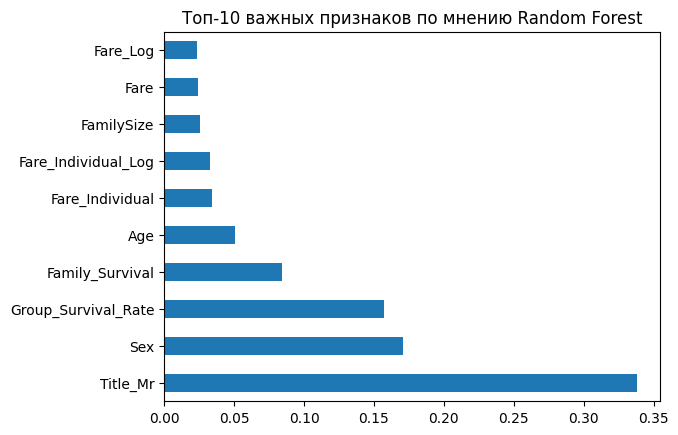

Text(50.722222222222214, 0.5, 'Actual')

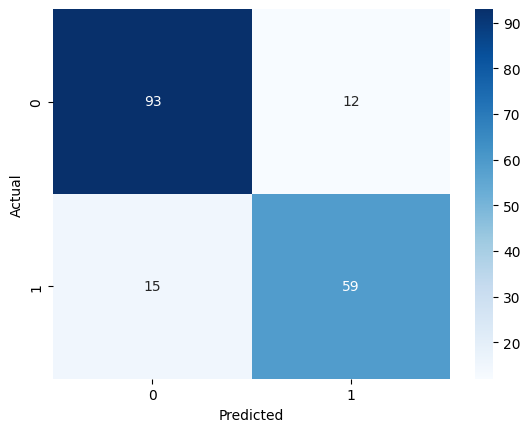

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
rf_model.fit(X_train, y_train)

importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=True).head(40))
importances.nlargest(10).plot(kind='barh')
plt.title('Топ-10 важных признаков по мнению Random Forest')
plt.show()

errors_df = val_df_raw.copy()
errors_df['Actual'] = val_df_raw['Survived']
errors_df['Predicted'] = rf_model.predict(X_val)
errors = errors_df[errors_df['Actual'] != errors_df['Predicted']]
errors.head(10)

y_probs = rf_model.predict_proba(X_val)[:, 1]
y_pred_custom = (y_probs >= 0.5).astype(int)
sns.heatmap(confusion_matrix(y_val, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')